# **Amazon Lookout for Equipment** - Demonstration on an anonymized expander dataset
*Part 1: Data preparation*

**Change your bucket name here:**

In [1]:
# BUCKET = '<YOUR_BUCKET_NAME_HERE>'
# PREFIX = 'data'


BUCKET = 'sagemaker-lookout-equipment-demo'
PREFIX = 'data4'

## Initialization
---
This repository is initially structured as follow:
```
/lookout-equipment-demo
|
+-- dataset/                                <<< Original dataset <<<
|   |-- labels.csv
|   |-- tags_description.csv
|   |-- timeranges.txt
|   \-- timeseries.zip
|
+-- notebooks/
|   |-- 1_data_preparation.ipynb            <<< This notebook <<<
|   |-- 2_dataset_creation.ipynb
|   |-- 3_model_training.ipynb
|   |-- 4_model_evaluation.ipynb
|   \-- 5_inference_scheduling.ipynb
|
+-- utils/
    \-- lookout_equipment_utils.py
```

### Notebook configuration update
Amazon Lookout for Equipment being a very recent service, we need to make sure that we have access to the latest version of the AWS Python packages. If you see a `pip` dependency error, check that the `boto3` version is ok: if it's greater than 1.17.48 (the first version that includes the `lookoutequipment` API), you can discard this error and move forward with the next cell:

In [2]:
!pip install --quiet --upgrade boto3 tqdm tsia

import boto3
print(f'boto3 version: {boto3.__version__} (should be >= 1.17.48 to include Lookout for Equipment API)')

# Restart the current notebook to ensure we take into account the previous updates:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

boto3 version: 1.17.53 (should be >= 1.17.48 to include Lookout for Equipment API)


### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import shutil
import sys
import tsia
import warnings

from tqdm import tqdm

In [4]:
sys.path.append('../utils')
import lookout_equipment_utils as lookout

### Parameters

In [5]:
RAW_DATA   = os.path.join('..', 'dataset')
DATA       = os.path.join('..', 'data')
LABEL_DATA = os.path.join(DATA, 'labelled-data')
TRAIN_DATA = os.path.join(DATA, 'training-data', 'expander')

os.makedirs(DATA,       exist_ok=True)
os.makedirs(LABEL_DATA, exist_ok=True)
os.makedirs(TRAIN_DATA, exist_ok=True)

In [6]:
%matplotlib inline
plt.style.use('Solarize_Light2')
plt.rcParams['lines.linewidth'] = 0.5
warnings.filterwarnings("ignore")

## Loading datasets of interest
---
### Analysis time ranges
The dataset provided with this repository is one year long with some known anomaly periods appearing both at the beginning and at the end of the year. Using the following training / evaluation split, will allow Lookout for Equipment to have labelled periods on both side of the split date:

In [7]:
timeranges_fname = os.path.join(DATA, 'timeranges.txt')
shutil.copyfile(os.path.join(RAW_DATA, 'timeranges.txt'), timeranges_fname)
with open(timeranges_fname, 'r') as f:
    timeranges = f.readlines()
    
training_start   = pd.to_datetime(timeranges[0][:-1])
training_end     = pd.to_datetime(timeranges[1][:-1])
evaluation_start = pd.to_datetime(timeranges[2][:-1])
evaluation_end   = pd.to_datetime(timeranges[3][:-1])

print(f'Training period: from {training_start} to {training_end}')
print(f'Evaluation period: from {evaluation_start} to {evaluation_end}')

Training period: from 2015-01-01 00:00:00 to 2015-08-31 23:59:00
Evaluation period: from 2015-09-01 00:00:00 to 2015-11-30 23:59:00


### Labels
Historical maintenance record time ranges are recorded in a CSV files with two columns containing *start time* and *end time* of each range:

In [8]:
labels_fname = os.path.join(LABEL_DATA, 'labels.csv')
shutil.copyfile(os.path.join(RAW_DATA, 'labels.csv'), labels_fname)
labels_df = pd.read_csv(os.path.join(LABEL_DATA, 'labels.csv'), header=None)
labels_df[0] = pd.to_datetime(labels_df[0])
labels_df[1] = pd.to_datetime(labels_df[1])
labels_df.columns = ['start', 'end']
labels_df.head()

,start,end
0,2015-01-10 10:00:00,2015-01-10 20:00:00
1,2015-01-15 13:00:00,2015-01-16 15:00:00
2,2015-03-05 10:00:00,2015-03-27 00:00:00
3,2015-03-29 10:00:00,2015-03-29 19:00:00
4,2015-11-11 18:00:00,2015-11-13 12:00:00


### Time series
The raw timeseries is a zipped parquet file, let's deflate it:

In [9]:
timeseries_fname = os.path.join(RAW_DATA, 'timeseries.zip')
!unzip -o $timeseries_fname -d $DATA/training-data

Archive:  ../dataset/timeseries.zip
  inflating: ../data/training-data/expander.parquet  


The dataframe stored there has 122 tags and 480,886 rows, ranging from *January 1st* to *November 30, 2015*:

In [10]:
all_tags_fname = os.path.join(DATA, 'training-data', 'expander.parquet')
table = pq.read_table(all_tags_fname)
all_tags_df = table.to_pandas()
del table

print(all_tags_df.shape)
all_tags_df.head()

(480886, 122)


,signal-001,signal-002,signal-003,signal-004,signal-005,signal-006,signal-007,signal-008,signal-009,signal-010,...,signal-113,signal-114,signal-115,signal-116,signal-117,signal-118,signal-119,signal-120,signal-121,signal-122
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.392371,0.545005,0.296774,0.413289,0.170744,0.482980,0.222063,0.268691,0.749860,0.475116,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.764706,0.810345
2015-01-01 00:01:00,0.389415,0.569155,0.290645,0.415646,0.142368,0.532297,0.222063,0.290804,0.776781,0.486884,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.779412,0.810345
2015-01-01 00:02:00,0.378179,0.547750,0.290645,0.406456,0.160959,0.470115,0.235673,0.277115,0.782389,0.472665,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.764706,0.810345
2015-01-01 00:03:00,0.381135,0.547750,0.284516,0.401744,0.170744,0.498794,0.249284,0.270446,0.771733,0.484432,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.764706,0.810345
2015-01-01 00:04:00,0.381135,0.553238,0.284516,0.406456,0.142368,0.493433,0.194842,0.272025,0.749860,0.484432,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.764706,0.810345


### Tags description

This dataset comes with a tag description file including:

* `Tag`: the tag name as it is recorded by the customer in his historian system (for instance the [Honeywell process history database](https://www.honeywellprocess.com/en-US/explore/products/advanced-applications/uniformance/Pages/uniformance-phd.aspx))
* `UOM`: the unit of measure for the recorded signal
* `Subsystem`: an ID linked to the part of the asset this sensor is attached to

In [11]:
tags_description_fname = os.path.join(RAW_DATA, 'tags_description.csv')
tags_description_df = pd.read_csv(tags_description_fname)
tags_description_df.head()

,Tag,UOM,Subsystem
0,signal-001,micra pp,subsystem-05
1,signal-002,micra pp,subsystem-05
2,signal-003,micra pp,subsystem-05
3,signal-004,micra pp,subsystem-05
4,signal-005,micra pp,subsystem-08


Let's extract a list of features from this table: we group them by unit of measure for more convenience:

In [12]:
features = list(tags_description_df.sort_values(by='UOM')['Tag'])

## Dataset overview
---

Build a list of dataframes, one per feature (this will be useful for visualizations purpose). An early event in the year skews the data: we remove that part for visualization purpose only (hence the `start` and `end` range definition below), but will keep the period starting January 1st as a training period later on.

In [13]:
start = pd.to_datetime('2015-04-05 00:00:00')
end = evaluation_end

df_list = []
feature_groups = dict()
for f in features:
    # Get the unit of measure for the current feature:
    uom = str(list(tags_description_df.loc[tags_description_df['Tag'] == f, 'UOM'])[0])
    
    # We have already some features in this group, add it:
    if uom in feature_groups.keys():
        feature_groups.update({uom: feature_groups[uom] + [f]})
        
    # Otherwise, create this group:
    else:
        feature_groups.update({uom: [f]})
    
    # Add the dataframe to the list:
    current_df = all_tags_df.loc[start:end, [f]]
    current_df = current_df.replace(np.nan, 0.0)
    df_list.append(current_df)

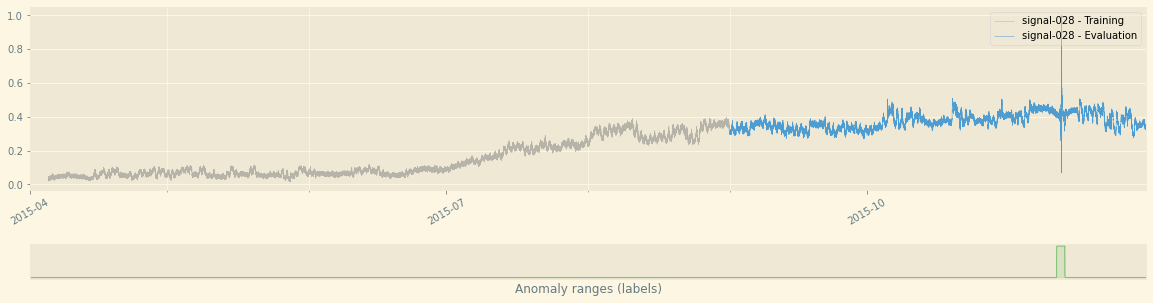

In [14]:
tag = 'signal-028'
tag_df = all_tags_df.loc[start:end, [tag]]
tag_df.columns = ['Value']

fig, axes = lookout.plot_timeseries(
    tag_df, 
    tag, 
    fig_width=20, 
    tag_split=evaluation_start, 
    labels_df=labels_df
)

Run the following two cells **only on instances with high memory** (at least `ml.m5.xlarge`): on smaller instances, the image generated by `matplotlib` are too large to be displayed:

In [ ]:
fig = tsia.plot.plot_multivariate_timeseries(
    timeseries_list=df_list,
    tags_list=features,
    split_date=evaluation_start,
    tags_description_df=tags_description_df,
    tags_grouping_key='UOM',
    num_cols=4,
    col_size=5
)

In [ ]:
%%time
# Discretize each signal in 3 bins:
array = tsia.markov.discretize_multivariate(df_list)

# Grouping the signals based on their unit of measure (UOM):
num_timesteps = array.shape[1]
separator = np.zeros(shape=(1, num_timesteps))
separator = np.where(separator==0, np.nan, separator)
grouped_array = []
signal_list = []
current_row = 0
for uom in feature_groups.keys():
    num_features = len(feature_groups[uom])
    signal_list = signal_list + features[current_row:current_row + num_features + 1]
    signal_list.append(uom)
    grouped_array.append(array[current_row:current_row + num_features + 1])
    grouped_array.append(separator)
    current_row += num_features
grouped_array = np.concatenate(grouped_array)

# Plot the strip chart:
tsia.plot.plot_timeseries_strip_chart(
  grouped_array, 
  signal_list=signal_list,
  fig_width=20,
  dates=df_list[0].index.to_pydatetime(),
  day_interval=2
)

## Building and uploading the dataset
---
We will structure our S3 bucket like this:
```
s3://sagemaker-lookout-equipment-demo/
|
+-- training-data/
|   |
|   +-- expander/
|       |
|       +-- subsystem-01
|       |   \-- subsystem-01.csv
|       |
|       +-- subsystem-02
|       |   \-- subsystem-02.csv
|       |
|       +-- ...
|       |
|       \-- subsystem-24
|           \-- subsystem-24.csv
|
+-- labelled-data/
    |
    \-- labels.csv
```

In [15]:
# Process each subsystem one by one:
components = list(tags_description_df['Subsystem'].unique())
progress_bar = tqdm(components)
for component in progress_bar:
    progress_bar.set_description(f'Component {component}')
    progress_bar.refresh()
    
    # Check if CSV file already exist and do not overwrite it:
    component_tags_fname = os.path.join(TRAIN_DATA, f'{component}', f'{component}.csv')
    if not os.path.exists(component_tags_fname):
        # Build the dataframe with all the signal timeseries for the current subsystem:
        component_tags_list = list(tags_description_df[tags_description_df['Subsystem'] == component]['Tag'])
        component_tags_df = all_tags_df[component_tags_list]
        component_tags_df = component_tags_df.reset_index()
        component_tags_df['Timestamp'] = component_tags_df['Timestamp'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f')
        
        # Save to disk:
        os.makedirs(os.path.join(TRAIN_DATA, f'{component}'), exist_ok=True)
        component_tags_df.to_csv(component_tags_fname, index=None)

Component subsystem-17: 100%|██████████| 24/24 [00:00<00:00, 398.16it/s]


In [16]:
# Uploading training dataset to S3:
training_src_dir = TRAIN_DATA
training_s3_dest_path = f's3://{BUCKET}/{PREFIX}/training-data/expander'
!aws s3 cp --recursive $training_src_dir $training_s3_dest_path

upload: ../data/training-data/expander/subsystem-03/subsystem-03.csv to s3://sagemaker-lookout-equipment-demo/data4/training-data/expander/subsystem-03/subsystem-03.csv
upload: ../data/training-data/expander/subsystem-06/subsystem-06.csv to s3://sagemaker-lookout-equipment-demo/data4/training-data/expander/subsystem-06/subsystem-06.csv
upload: ../data/training-data/expander/subsystem-01/subsystem-01.csv to s3://sagemaker-lookout-equipment-demo/data4/training-data/expander/subsystem-01/subsystem-01.csv
upload: ../data/training-data/expander/subsystem-02/subsystem-02.csv to s3://sagemaker-lookout-equipment-demo/data4/training-data/expander/subsystem-02/subsystem-02.csv
upload: ../data/training-data/expander/subsystem-04/subsystem-04.csv to s3://sagemaker-lookout-equipment-demo/data4/training-data/expander/subsystem-04/subsystem-04.csv
upload: ../data/training-data/expander/subsystem-10/subsystem-10.csv to s3://sagemaker-lookout-equipment-demo/data4/training-data/expander/subsystem-10/sub

In [17]:
# Uploading label dataset to S3:
label_src_fname = os.path.join(LABEL_DATA, 'labels.csv')
label_s3_dest_path = f's3://{BUCKET}/{PREFIX}/labelled-data/labels.csv'
!aws s3 cp $label_src_fname $label_s3_dest_path

upload: ../data/labelled-data/labels.csv to s3://sagemaker-lookout-equipment-demo/data4/labelled-data/labels.csv


## Conclusion
---
At this stage, we have built:
* A single Parquet dataset that contains all the historical data for all tags provided by the customer: this is **58,668,092** at a **1 minute** sampling rate for **122 tags**.
* **24 individual CSV files** (1 for each subsystem, each subsystem can contain several timeseries) filed in their respective subsystem directories

Looking at the plot for **signal-028** above, we are going to try and predict the event that happens on **November 2015**: to achieve this, we will use a training set spanning from **January 2015** to **August 2015** and we will test on **September 2015** to **November 2015**.